In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from matplotlib.colors import ListedColormap
from scipy.stats import norm, multivariate_normal

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls "/content/gdrive/My Drive/PRML Dataset/Assignment2-Datasets/Dataset4"

A2Q3.csv


In [ ]:
class GMM:
  def __init__(self, n_components: int, n_iters: int, tol: float, seed: int):
    self.n_components = n_components
    self.n_iters = n_iters
    self.tol = tol
    self.seed = seed

  def fit(self, X):
    n_row, n_col = X.shape     
    self.resp = np.zeros((n_row, self.n_components))
    np.random.seed(self.seed)
    chosen = np.random.choice(n_row, self.n_components, replace = False)
    self.means = X[chosen]
    self.weights = np.full(self.n_components, 1 / self.n_components)
    shape = self.n_components, n_col, n_col
    self.covs = np.full(shape, np.cov(X, rowvar = False))

    log_likelihood = 0
    self.converged = False
    self.logLikelihoodHistory = []      

    for i in range(self.n_iters):
      log_likelihood_new = self.Expectaion(X)
      self.Maximise(X)

      if abs(log_likelihood_new - log_likelihood) <= self.tol:
        self.converged = True
        break

      log_likelihood = log_likelihood_new
      self.logLikelihoodHistory.append(log_likelihood)

    return self

  def Expectaion(self, X):
    self._compute_log_likelihood(X)
    log_likelihood = np.sum(np.log(np.sum(self.resp, axis = 1)))
    self.resp = self.resp / self.resp.sum(axis = 1, keepdims = 1)
    return log_likelihood

  def _compute_log_likelihood(self, X):
    for k in range(self.n_components):
        prior = self.weights[k]
        likelihood = multivariate_normal(self.means[k], self.covs[k]).pdf(X)
        self.resp[:, k] = prior * likelihood

    return self

  def Maximise(self, X):
    resp_weights = self.resp.sum(axis = 0)
    self.weights = resp_weights / X.shape[0]
    weighted_sum = np.dot(self.resp.T, X)
    self.means = weighted_sum / resp_weights.reshape(-1, 1)
    for k in range(self.n_components):
        diff = (X - self.means[k]).T
        weighted_sum = np.dot(self.resp[:, k] * diff, diff.T)
        self.covs[k] = weighted_sum / resp_weights[k]
        
    return self

In [ ]:
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot(data[:, 0], data[:, 1], 'ko')

    delta = 0.025
    k = means.shape[0]
    x = np.arange(data[:, 0].min() - 1.0, data[:, 0].max() + 1.0, delta)
    y = np.arange(data[:, 1].min() - 1.0, data[:, 1].max() + 1.0, delta)
    x_grid, y_grid = np.meshgrid(x, y)
    coordinates = np.array([x_grid.ravel(), y_grid.ravel()]).T

    col = ['blue', 'red', 'green', 'orange', 'yellow', 'violet']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        z_grid = multivariate_normal(mean, cov).pdf(coordinates).reshape(x_grid.shape)
        plt.contour(x_grid, y_grid, z_grid, colors = col[i])

    plt.title(title)
    plt.tight_layout()

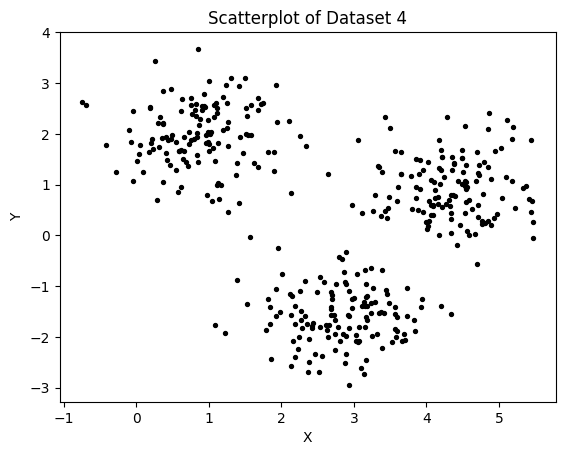

In [6]:
X = pd.read_csv("/content/gdrive/My Drive/PRML Dataset/Assignment2-Datasets/Dataset4/A2Q3.csv", sep = ',', header=None)
X = np.array(X)

x = X[:, 0] 
y = X[:, 1]

plt.scatter(x, y, color = "black", s = 8)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot of Dataset 4')
plt.show()

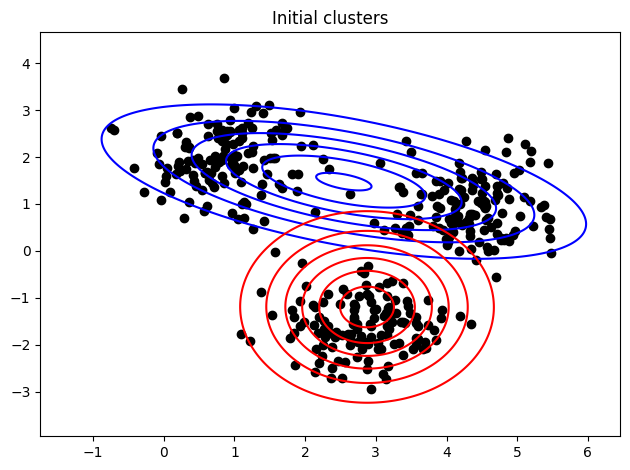

In [ ]:

gmm = GMM(n_components = 2, n_iters = 1, tol = 1e-4, seed = 12)
gmm.fit(np.array(X))

plot_contours(np.array(X), gmm.means, gmm.covs, 'Initial clusters')

converged iteration: 9


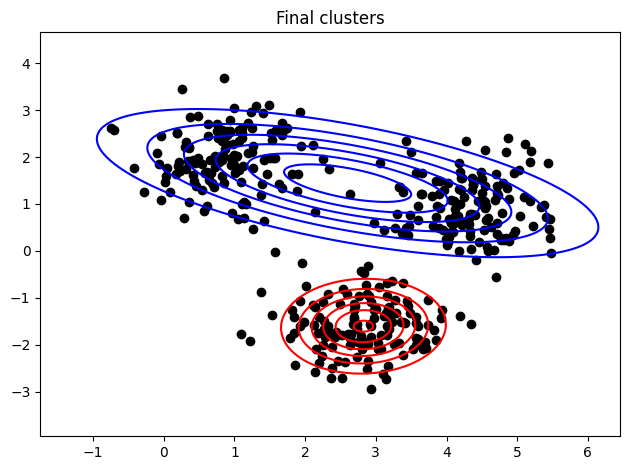

Text(0, 0.5, 'Log Likelihood')

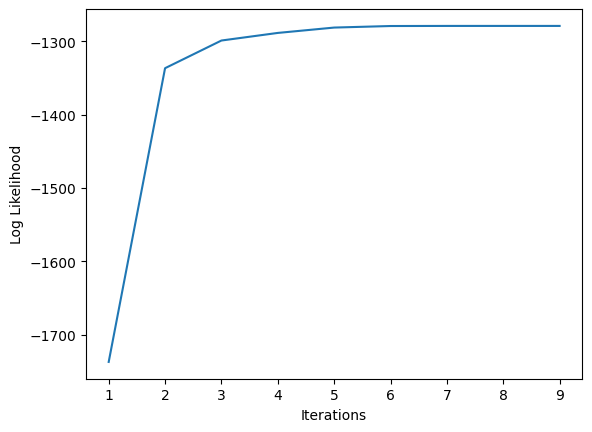

In [ ]:
gmm = GMM(n_components = 2, n_iters = 50, tol = 1e-4, seed = 12)
gmm.fit(X)

print('converged iteration:', len(gmm.logLikelihoodHistory))
plot_contours(X, gmm.means, gmm.covs, 'Final clusters')
plt.show()
plt.plot(range(1, 10), gmm.logLikelihoodHistory[:9], label = f'k = 2')
  # print(gmm.logLikelihoodHistory[-1])
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')

In [ ]:
print(gmm.logLikelihoodHistory)

[-1642.6541831417676, -1454.1447485519093, -1432.22062383117, -1396.8455600012808, -1353.8656099030427, -1285.0521239235777, -1198.2430438785939, -1155.6280745109061, -1153.2130690549457, -1153.1004500245972, -1153.092853751562, -1153.0922429806337]


converged iteration: 9
converged iteration: 10
converged iteration: 254
converged iteration: 94
converged iteration: 254


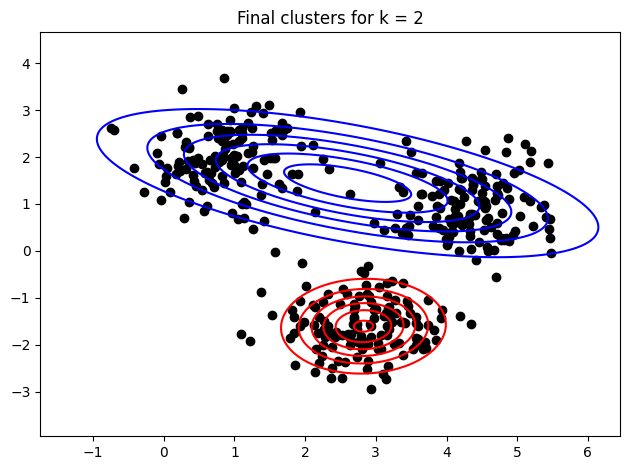

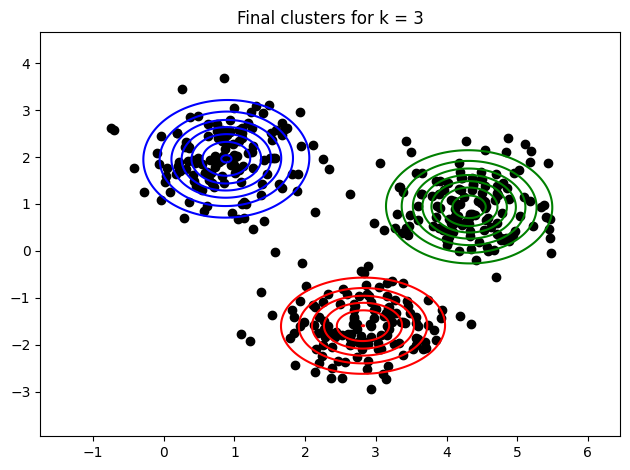

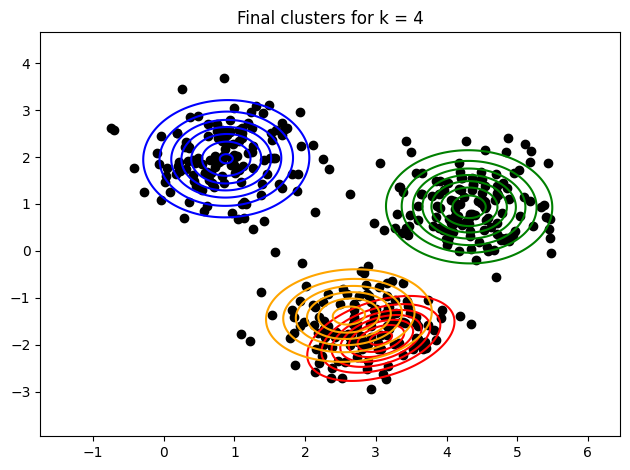

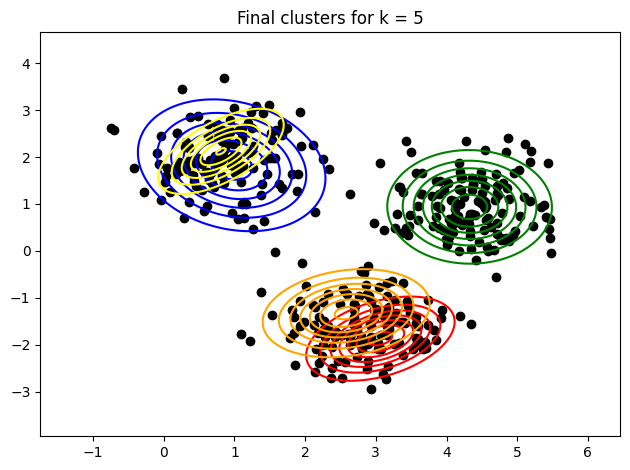

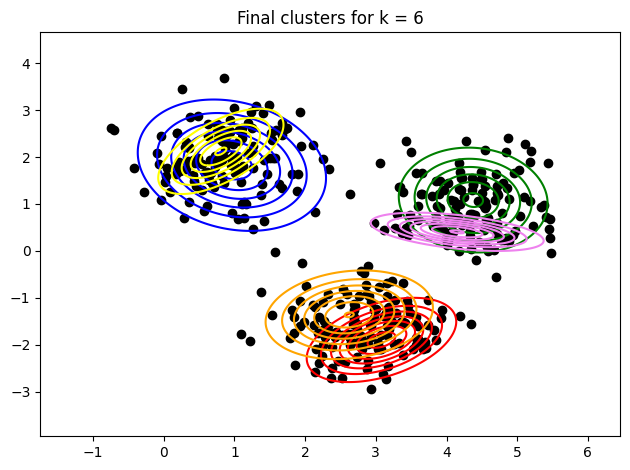

In [ ]:
for i in range(2, 7):  
  gmm = GMM(n_components = i, n_iters = 1000, tol = 1e-4, seed = 12)
  gmm.fit(np.array(X))

  print('converged iteration:', len(gmm.logLikelihoodHistory))
  plot_contours(np.array(X), gmm.means, gmm.covs, f'Final clusters for k = {i}')
  

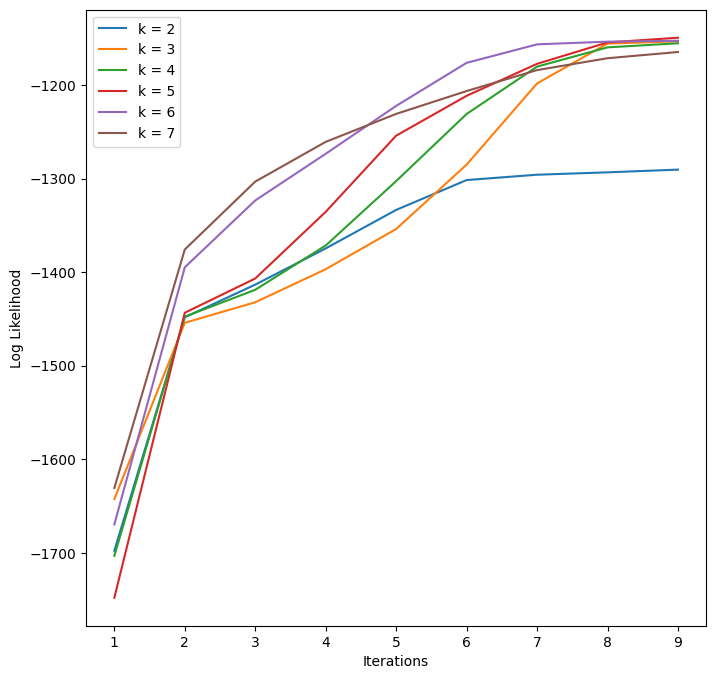

In [ ]:
plt.figure(figsize=(8,8), dpi=100)
for i in range(2, 8):
  gmm = GMM(n_components = i, n_iters = 1000, tol = 1e-4, seed = 4)
  gmm.fit(np.array(X))
  plt.plot(range(1, 10), gmm.logLikelihoodHistory[:9], label = f'k = {i}')
  # print(gmm.logLikelihoodHistory[-1])
plt.xlabel('Iterations')
plt.ylabel('Log Likelihood')
plt.legend()
plt.show()

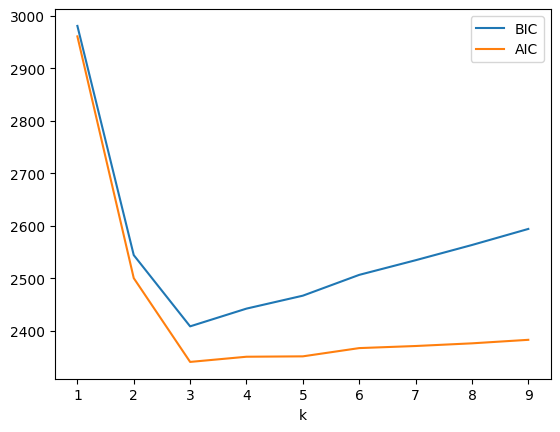

In [ ]:
from sklearn.mixture import GaussianMixture
n_components = np.arange(1, 10)
clfs = [GaussianMixture(n, max_iter = 1000).fit(X) for n in n_components]
bics = [clf.bic(X) for clf in clfs]
aics = [clf.aic(X) for clf in clfs]

plt.plot(n_components, bics, label = 'BIC')
plt.plot(n_components, aics, label = 'AIC')
plt.xlabel('k')
plt.legend()
plt.show()

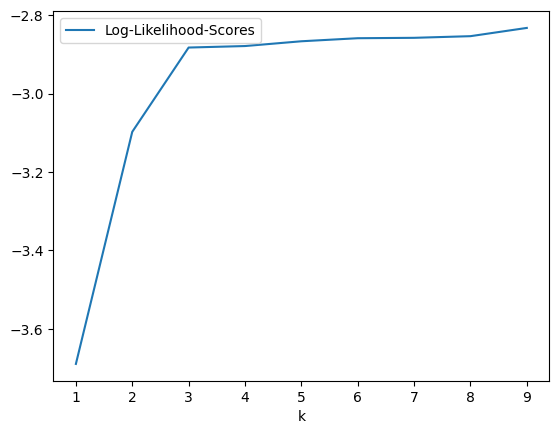

In [ ]:
scores = [clf.score(X) for clf in clfs]
plt.plot(n_components, scores, label = 'Log-Likelihood-Scores')
plt.xlabel('k')
plt.legend()
plt.show()

As we have used log likelihood scores in the previous part we won't be including this graph in our conclusions. 

<ipython-input-32-c5462c393749>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, S, 'bo-', color='blue')


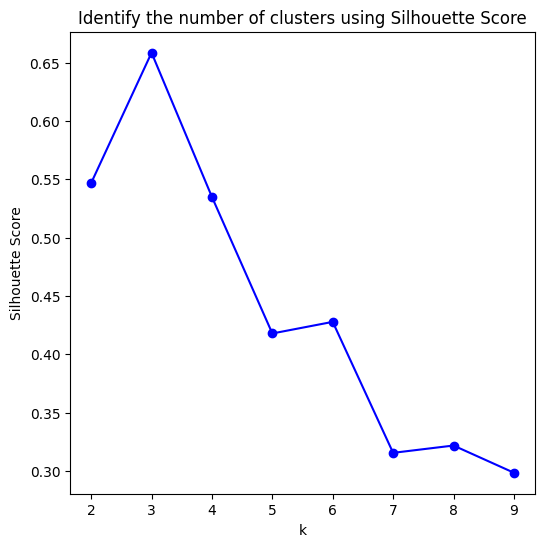

In [ ]:
from sklearn import metrics
K = range(2, 10)
S = []
for k in range(2, 10):
    model = GaussianMixture(n_components=k, n_init=20, init_params='kmeans')
    labels = model.fit_predict(X)
    S.append(metrics.silhouette_score(X, labels, metric='euclidean'))

# Plot the resulting Silhouette scores on a graph
plt.figure(figsize=(6,6), dpi=100)
plt.plot(K, S, 'bo-', color='blue')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Identify the number of clusters using Silhouette Score')
plt.show()